In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path

In [2]:
# !git clone https://github.com/xiaoh/para-database-for-PIML.git

In [3]:
# data = np.genfromtxt('/kaggle/working/para-database-for-PIML/pehill-5-cases-DNS/case_1p2/dns-data/mean_files.dat',)
# print(data.shape)

In [4]:
# x, y, u, v, desconocido, p = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5]
# flow_variables_arrays = [u, v, p]

In [5]:
# data[:, 1].max()

In [6]:
DATASET_NAME = 'komegasst'
DATASET_BASE_PATH = Path('/kaggle/input/ml-turbulence-dataset')

In [7]:
def load_combined_array(cases, field):
    data = np.concatenate(
        [
            np.load(
                DATASET_BASE_PATH
                / DATASET_NAME
                / (DATASET_NAME + "_" + case + "_" + field + ".npy")
            )
            for case in cases
        ]
    )
    return data

def load_label_data(cases, field):
    data = np.concatenate(
        [
            np.load(
                DATASET_BASE_PATH
                / 'labels'
                / (case + "_" + field + ".npy")
            )
            for case in cases
        ]
    )
    return data

In [8]:
cases = ["PHLL_case_1p0"]
x = load_combined_array(cases, "Cx")
y = load_combined_array(cases, "Cy")
flow_variables = ["Ux", "Uy", "p"]
flow_variables_arrays = [
    load_combined_array(cases, variable) for variable in flow_variables
]
label_variables = ['uv', 'uu', 'vv']
label_arrays = [
    load_label_data(cases, variable) for variable in label_variables
]
flow_variables_arrays = flow_variables_arrays + label_arrays

# prueba para ver si imitando esto funciona mejor
# uv = scal[8][:, ind] - u*v
# uu = scal[4][:, ind] - u**2
# vv = scal[5][:, ind] - v**2
# flow_variables_arrays[3] -= flow_variables_arrays[0] * flow_variables_arrays[1]
# flow_variables_arrays[4] -= flow_variables_arrays[0] ** 2
# flow_variables_arrays[5] -= flow_variables_arrays[1] ** 2

In [9]:
def plot_mesh(x, y):
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111)
    ax.scatter(x, y, c='k', s=0.1)
    ax.set_title('Mesh')
    ax.set_aspect(1)

In [10]:
def plot_flow_variables(x, y, *variables):
    n_variables = len(variables)
    fig, ax = plt.subplots(n_variables, 1, figsize=(12,12))
    for i, variable in enumerate(variables):
        contour = ax[i].tricontourf(x.flatten(), y.flatten(), variable.flatten(), levels=50)
        ax[i].set_aspect(1)
        fig.colorbar(contour, ax=ax[i])
        

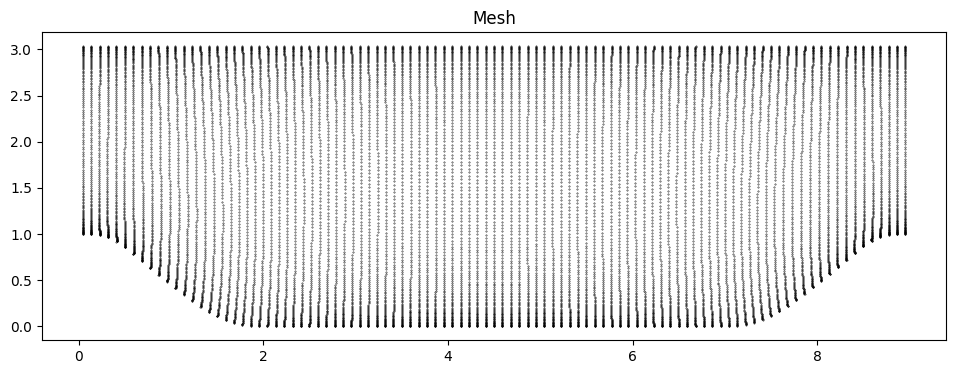

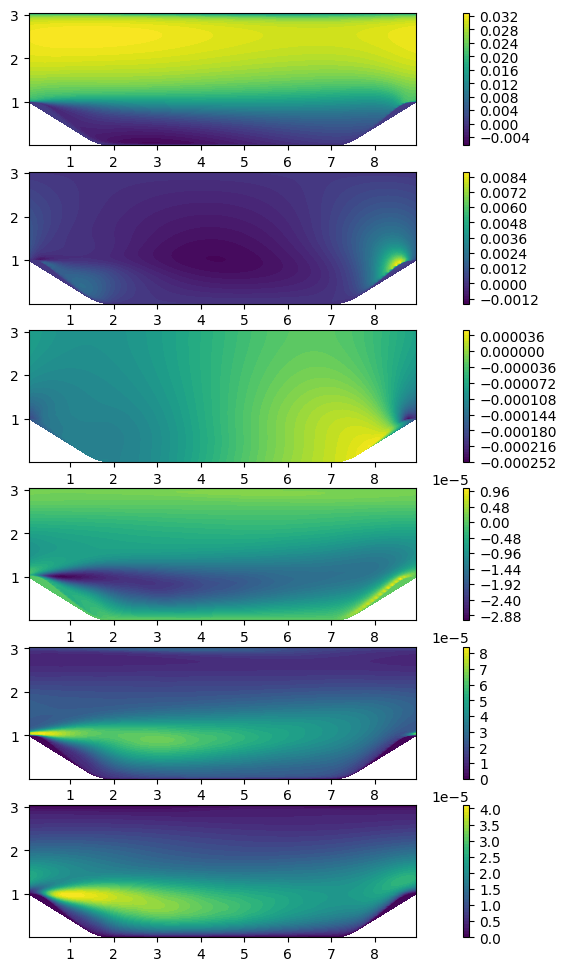

In [11]:
plot_mesh(x, y)
plot_flow_variables(x, y, *flow_variables_arrays)

Choose random collocation points

In [12]:
def get_collocation_points(x_train, y_train, n_points=7000):
    idx = np.random.choice(x_train.shape[0], n_points, replace=False)
    x_train = torch.tensor(x_train[idx, :], dtype=torch.float32)
    y_train = torch.tensor(y_train[idx, :], dtype=torch.float32)
    return x_train, y_train

In [13]:
x_train = np.stack((x, y), axis=1)
y_train = np.stack((flow_variables_arrays), axis=1)
print(x_train.shape, y_train.shape)
n_points = 4000
x_train, y_train = get_collocation_points(x_train, y_train, n_points)

(14751, 2) (14751, 6)


define pde

In [14]:
# TODO: mover esto 
# WARN: posible fuente de error
kinematic_nu = 5e-6
density = 1 # ??
nu = kinematic_nu * density

def pde_loss(x, y, pred):
    u, v, p, uv, uu, vv = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3], pred[:, 3:4], pred[:, 4:5], pred[:, 5:6]
#     u, v, p = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
    uv_x = torch.autograd.grad(uv, x, grad_outputs=torch.ones_like(uv), create_graph=True)[0]
    uv_y = torch.autograd.grad(uv, y, grad_outputs=torch.ones_like(uv), create_graph=True)[0]
    uu_x = torch.autograd.grad(uu, x, grad_outputs=torch.ones_like(uu), create_graph=True)[0]
    vv_y = torch.autograd.grad(vv, y, grad_outputs=torch.ones_like(vv), create_graph=True)[0]
    
    f =  u * u_x + v * u_y + p_x - nu * (u_xx + u_yy) + uu_x + uv_y
    g =  u * v_x + v * v_y + p_y - nu * (v_xx + v_yy) + uv_x + vv_y
    cont = u_x + v_y
    
    f_loss = (f ** 2).mean()
    g_loss = (g ** 2).mean()
    
    return f_loss + g_loss + (cont ** 2).mean()


In [15]:
def boundary_conditions_loss():
    pass

define the model

In [16]:
class Net(nn.Module):
    def __init__(self, layer_dim):
        super().__init__()

        self.num_layers = len(layer_dim)
        self.layers = nn.ModuleList()
        for i in range(1, self.num_layers):
            self.layers.append(nn.Linear(layer_dim[i - 1], layer_dim[i]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.tanh(layer(x))
        x = self.layers[-1](x)
        return x


class PirateNetBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(PirateNetBlock, self).__init__()
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x, u, v):
        f = F.tanh(self.dense1(x))
        z1 = f * u + (1 - f) * v
        g = F.tanh(self.dense2(z1))
        z2 = g * u + (1 - g) * v
        h = F.tanh(self.dense3(z2))
        return self.alpha * h + (1 - self.alpha) * x


class PirateNet(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        num_blocks,
        hidden_dim=256,
        s=1.0,
        activation=F.tanh,
    ):
        super(PirateNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_blocks = num_blocks
        self.hidden_dim = hidden_dim
        self.s = s
        self.activation = activation

        self.B = nn.Parameter(torch.randn(input_dim, hidden_dim // 2) * s)
        self.embedding = lambda x: torch.cat(
            [torch.cos(torch.matmul(x, self.B)), torch.sin(torch.matmul(x, self.B))],
            dim=-1,
        )
        # (B, D) x (D, H) --> (B, H) --cat--> (B, 2*H)

        self.blocks = nn.ModuleList(
            [PirateNetBlock(hidden_dim) for _ in range(num_blocks)]
        )
        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)

        # Final layer
        self.final_layer = nn.Linear(hidden_dim, output_dim, bias=False)
        print(self.final_layer.weight.data.shape)

        self.initialize_weights()

    #         self.initialize_last_layer()

    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()

    def forward(self, x):
        x = self.embedding(x)
        u = self.activation(self.U(x))
        v = self.activation(self.V(x))
        for block in self.blocks:
            x = block(x, u, v)
        return self.final_layer(x)

    def initialize_last_layer(self, Y, input_data):
        phi = self.embedding(input_data)
        W = torch.linalg.lstsq(phi, Y).solution
        print(W.shape, self.final_layer.weight.data.shape)
        self.final_layer.weight.data = W.T


In [17]:
def train_model(model, optimizer, iterations, x_train, y_train):
    logs = {
        "iteration": [],
        "loss_from_pde": [],
        "loss_from_data": [],
        "total_loss": [],
    }
    def closure():
        x, y = x_train[:, 0:1], x_train[:, 1:2]
        x.requires_grad_(True)
        y.requires_grad_(True)
        input_tensor = torch.cat([x, y], dim=1)
        pred = model(input_tensor)

        optimizer.zero_grad()
        loss_from_data = F.mse_loss(pred, y_train)
#         loss_from_data = F.l1_loss(pred, y_train)
        loss_from_pde = pde_loss(x, y, pred)
        loss = loss_from_pde + loss_from_data
        loss.backward()
        closure.iteration += 1

        logs["iteration"].append(closure.iteration)
        logs["loss_from_pde"].append(loss_from_pde.item())
        logs["loss_from_data"].append(loss_from_data.item())
        logs["total_loss"].append(loss.item())
        if closure.iteration % 50 == 0:
            print(
                f"Iteration {closure.iteration}. Pde loss: {loss_from_pde.item()}, data loss: {loss_from_data.item()}"
            )
        return loss
    
    closure.iteration = 0
    try:
        for iteration in range(iterations):
            loss = optimizer.step(closure)
            
    except KeyboardInterrupt: 
        print('training stopped manually')
    
    return logs


def plot_training_logs(logs):
    plt.figure(figsize=(10, 6))
    plt.plot(logs["iteration"], logs["loss_from_pde"], label="PDE Loss")
    plt.plot(
        logs["iteration"], logs["loss_from_data"], label="Data Conditions Loss"
    )
    plt.plot(logs["iteration"], logs["total_loss"], label="Total Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Losses")
    plt.legend()
    plt.show()


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
x_train = x_train.to(device)
y_train = y_train.to(device)
#TODO: si esto funciona organizarlo bien
# from sklearn.preprocessing import StandardScaler
# std_scaler = StandardScaler()
# y_train = std_scaler.fit_transform(y_train)
# y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

In [20]:
input_dim = 2
output_dim = 6
n_layers = 8
layer_dim = 256
model_architecrure = [input_dim] + n_layers * [layer_dim] + [output_dim]

# model = Net(model_architecrure).to(device)
model = PirateNet(
    input_dim=input_dim,
    output_dim=output_dim,
    num_blocks=n_layers,
    hidden_dim=layer_dim,
).to(device)
# model.initialize_last_layer(y_train, x_train)

torch.Size([6, 256])


In [21]:
lr = 0.001
iterations = 8000
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
logs = train_model(model, optimizer, iterations, x_train, y_train)

Iteration 50. Pde loss: 0.006370410323143005, data loss: 0.03035539761185646
Iteration 100. Pde loss: 0.0002887462032958865, data loss: 0.0047561428509652615
Iteration 150. Pde loss: 9.866338223218918e-05, data loss: 0.0011142361909151077
Iteration 200. Pde loss: 4.880373307969421e-05, data loss: 0.0004451893037185073
Iteration 250. Pde loss: 2.8270689654164016e-05, data loss: 0.0002354595490032807
Iteration 300. Pde loss: 1.8425642338115722e-05, data loss: 0.00014235884009394795
Iteration 350. Pde loss: 1.3053358998149633e-05, data loss: 9.491368109593168e-05
Iteration 400. Pde loss: 9.77434956439538e-06, data loss: 6.800552364438772e-05
Iteration 450. Pde loss: 7.629192623426206e-06, data loss: 5.1251605327706784e-05
Iteration 500. Pde loss: 6.152891273814021e-06, data loss: 4.00291864934843e-05
Iteration 550. Pde loss: 5.0905532589240465e-06, data loss: 3.210249269613996e-05
Iteration 600. Pde loss: 4.295302005630219e-06, data loss: 2.6284282284905203e-05
Iteration 650. Pde loss: 3.

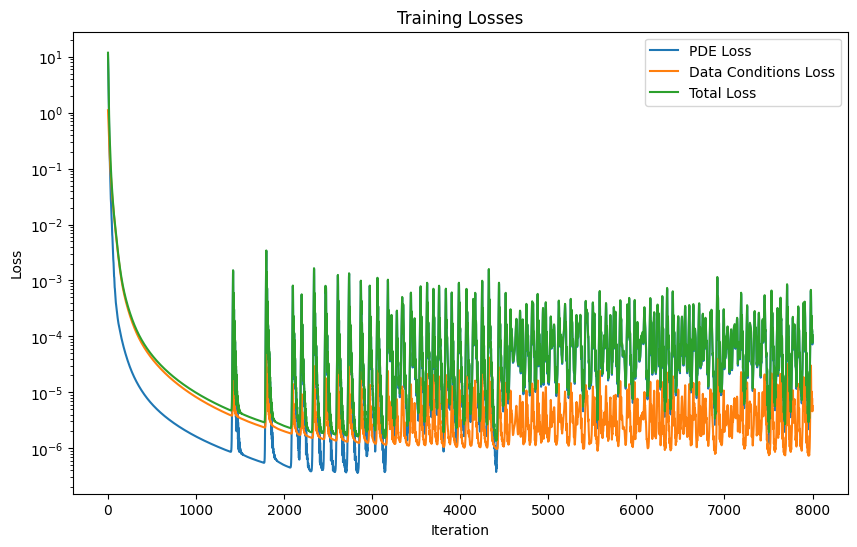

In [23]:
plot_training_logs(logs)

In [24]:
lr = 0.05
iterations = 1
optimizer = optim.LBFGS(
    model.parameters(),
    lr=lr,
    max_iter=12000,
    max_eval=12000,
    history_size=400,
    tolerance_grad=1e-11,
    tolerance_change=1e-14,
    line_search_fn="strong_wolfe",
)


Iteration 50. Pde loss: 2.420305463601835e-06, data loss: 1.1242872233196977e-06
Iteration 100. Pde loss: 6.416775022444199e-07, data loss: 8.151711199388956e-07
Iteration 150. Pde loss: 3.952683300667559e-07, data loss: 7.751463613203669e-07
Iteration 200. Pde loss: 3.1464736593989073e-07, data loss: 7.596025284328789e-07
Iteration 250. Pde loss: 2.8145865371698164e-07, data loss: 7.447781626979122e-07
Iteration 300. Pde loss: 2.615875587252958e-07, data loss: 7.279609803845233e-07
Iteration 350. Pde loss: 2.457593950566661e-07, data loss: 7.057758466544328e-07
Iteration 400. Pde loss: 2.3339143240264093e-07, data loss: 6.847752729299827e-07
Iteration 450. Pde loss: 2.1971354158267786e-07, data loss: 6.667422098871612e-07
Iteration 500. Pde loss: 2.0717990878438286e-07, data loss: 6.539846140185546e-07
Iteration 550. Pde loss: 1.9768239667428134e-07, data loss: 6.426444087992422e-07
Iteration 600. Pde loss: 1.8792965761349478e-07, data loss: 6.303962436504662e-07
Iteration 650. Pde lo

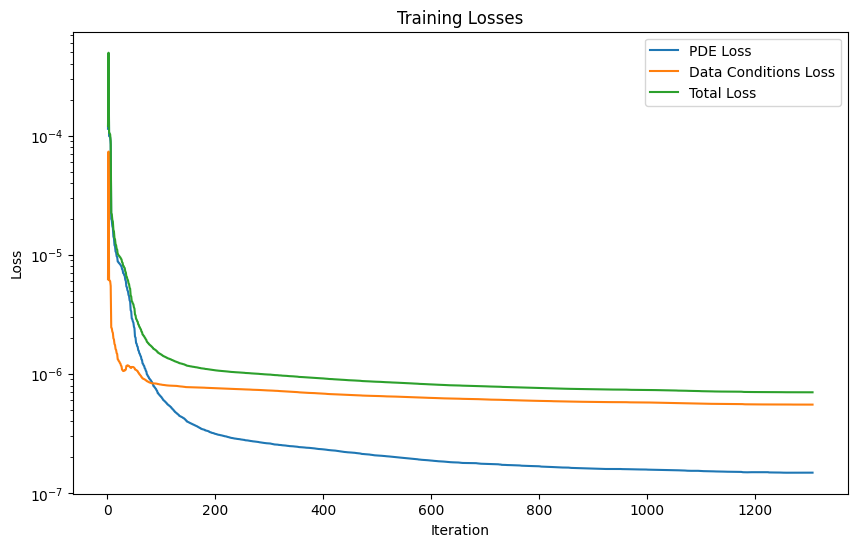

In [25]:
logs = train_model(model, optimizer, iterations, x_train, y_train)
plot_training_logs(logs)

In [26]:
torch.save(model.state_dict(), './model.pth')

In [27]:
def get_predictions(x, y, model):
    mesh = torch.tensor(np.stack((x, y), axis=1), dtype=torch.float32).to(device)
    preds = model(mesh)
#     preds = std_scaler.inverse_transform(preds.detach().cpu().numpy())
    return (
        preds[:, 0].detach().cpu().numpy(),
        preds[:, 1].detach().cpu().numpy(),
        preds[:, 2].detach().cpu().numpy(),
        preds[:, 3].detach().cpu().numpy(),
        preds[:, 4].detach().cpu().numpy(),
        preds[:, 5].detach().cpu().numpy(),
    )


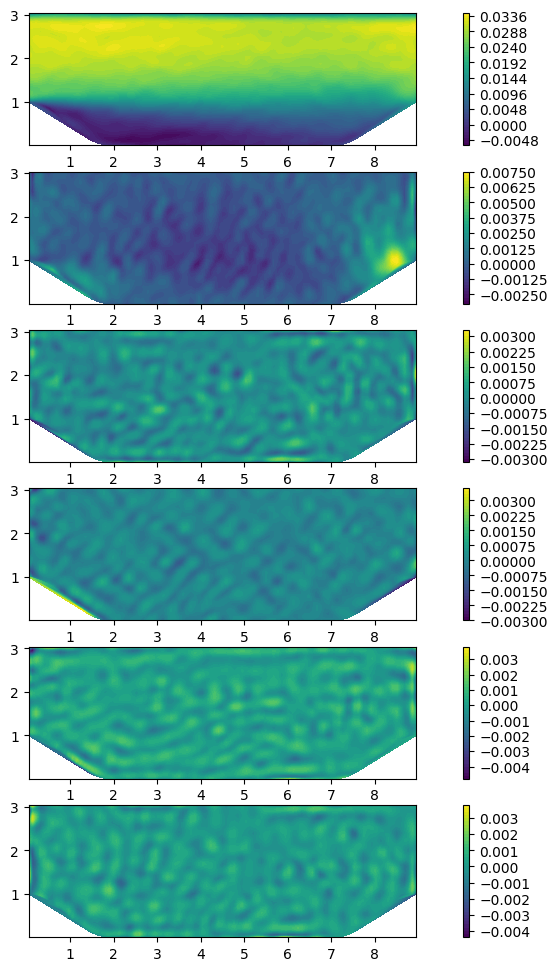

In [28]:
# u_pred, v_pred, p_pred, uv_pred, uu_pred, vv_pred = get_predictions(x, y, model)
# preds = [u_pred, v_pred, p_pred, uv_pred, uu_pred, vv_pred]
preds = get_predictions(x, y, model)
plot_flow_variables(x, y, *preds)

In [29]:
def relative_l2_error(u_predicted, u_exact):
    numerator = np.linalg.norm(u_predicted - u_exact, axis=1)
    denominator = np.linalg.norm(u_exact, axis=1)
    relative_error = numerator / denominator
    return relative_error

In [30]:
flow_absolute_errors = abs(flow_variables_arrays - np.stack(preds, axis=0))
flow_relative_errors = relative_l2_error(flow_variables_arrays, np.stack(preds, axis=0))

In [31]:
flow_relative_errors

array([0.07424298, 0.42315371, 0.99239976, 0.99930106, 0.99912096,
       0.99947596])

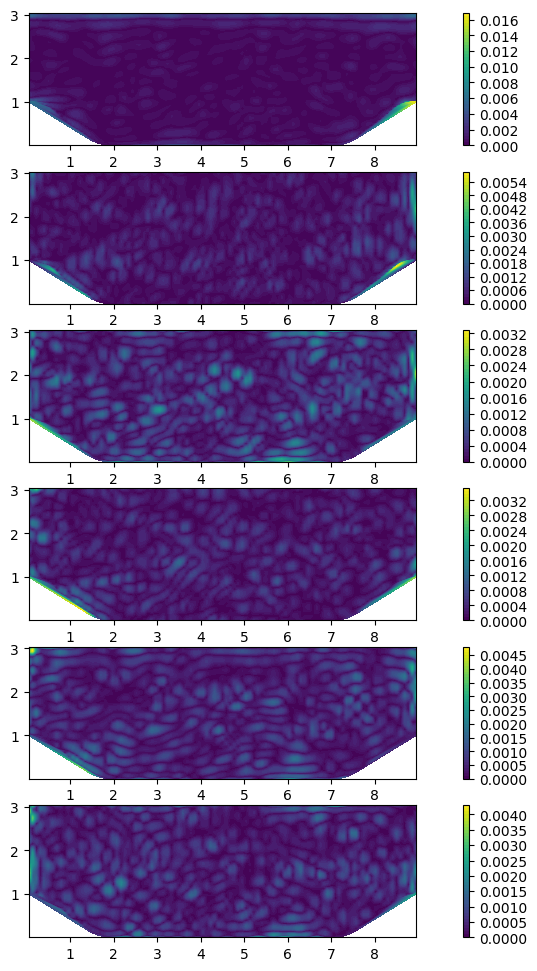

In [32]:
plot_flow_variables(x, y, *flow_absolute_errors)

In [33]:
!jupyter nbconvert --to pdf /kaggle/input/navier-stoke_problems_for_pinns/__notebook__.ipynb --output /kaggle/working/output.pdf

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] WARNING | pattern '/kaggle/input/navier-stoke_problems_for_pinns/__notebook__.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--Jupyt

In [34]:
# from IPython.display import display, HTML
# from pathlib import Path
# import os

# # Get the notebook name
# notebook_name = Path(os.path.basename(os.getcwd())) / Path(os.path.splitext(os.path.basename(os.path.join(os.getcwd(), 'notebook.ipynb')))[0])

# # Convert the notebook to HTML
# !jupyter nbconvert --to html {notebook_name}.ipynb

# # Display the HTML
# with open(f"{notebook_name}.html", "r") as f:
#     html = f.read()
# display(HTML(html))